# Credit Risk Modeling | Part 2: Probability of Default (PD) Model with Machine Learning, Performance Evaluation, Scorecard Development, and Loan Approval Cutoffs



### Probability of Default (PD)

The **Probability of Default (PD)** is a fundamental metric in credit risk modeling. It quantifies the likelihood that a borrower will fail to meet their debt obligations (such as credit card payments, mortgage, or other loans) within a specified time horizon, typically one year.

* In this notebook, we build the PD model using **logistic regression**, a widely-used classification method suitable for modeling binary outcomes (default vs. non-default).
* The logistic regression model outputs probabilities bounded between 0 and 1, which we interpret as the borrower's likelihood of default.

Mathematically, the logistic regression function is:

$$
P(Y=1|X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_k X_k)}}
$$

Where:

* $P(Y=1|X)$ is the probability of default given features $X$,
* $\beta_0$ is the intercept, and
* $\beta_i$ are the coefficients for features $X_i$.

The model is trained on historical loan data, learning the relationship between borrower characteristics and default risk.

---

### Model Performance Metrics

To evaluate the PD model’s predictive power, key metrics are calculated, including:

* **Accuracy:** The fraction of correct predictions over total predictions.
* **Area Under the Receiver Operating Characteristic Curve (AUC-ROC):** Measures model’s ability to distinguish between defaulters and non-defaulters across various threshold levels. A value above 0.5 indicates better-than-random classification.

These metrics guide model selection and tuning, ensuring a reliable probability estimation.

---

### Scorecard Development

A **credit scorecard** translates the logistic regression outputs into a simple, interpretable scoring system for practical use by credit officers and regulators. Scorecards meet Basel Accord requirements and regulatory expectations, emphasizing clarity and transparency.

**Why scorecards?**

* They discretize continuous variables into bins, facilitating intuitive explanations of risk drivers.
* They standardize scores within a fixed range, typically matching the well-known FICO score range of **300 to 850**.
* They allow easy communication of risk levels to non-technical stakeholders, enabling informed credit decisions.

The scorecard conversion uses the log-odds output from logistic regression and applies scaling factors to map probabilities to scores. The score for an individual attribute bin $i$ is computed as:

$$
\text{Score}_i = \text{Offset} + \text{Factor} \times \log \left( \frac{p_i}{1 - p_i} \right)
$$

Where $p_i$ is the predicted probability in bin $i$, and the **Factor** and **Offset** are constants chosen to align scores with the desired range.

---

### Loan Approval Cutoffs

An essential practical consideration is setting the **loan approval cutoff** score:

* Borrowers with scores **above the cutoff** are approved for loans, indicating acceptable credit risk.
* Borrowers with scores **below the cutoff** are rejected to mitigate potential losses.

Determining this cutoff involves balancing:

* The institution’s appetite for risk,
* The expected proportion of loan approvals versus rejections, and
* The economic impact of misclassifications (false positives and false negatives).

In formula terms, the cutoff corresponds to a threshold probability $p^*$:

$$
p^* = \frac{1}{1 + e^{-\text{Threshold Log-Odds}}}
$$

Where the threshold log-odds is chosen to optimize business objectives, such as maximizing profit or minimizing loss.

---

### Summary

This notebook covers the end-to-end process of building and validating a **Probability of Default (PD) model** using logistic regression, transforming it into an easy-to-understand scorecard, and establishing practical loan approval cutoffs. These steps empower financial institutions to make data-driven credit decisions that are both compliant with regulatory standards and aligned with business risk preferences.



# 1 Data Preparation

## a Importing Libraries

In [1]:
#installing gdown package to download dataset stored in G Drive
!pip install gdown
# to upgrade
!pip install --upgrade gdown


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
#libs for managing data
import numpy as np
import pandas as pd

#libs for ML regression model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics  
from sklearn.metrics import roc_curve, roc_auc_score

#libs for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#exporting ML model
import pickle

#lib to download dataset on g drive
import gdown

#setting display option max rows
#pd.options.display.max_rows = None

#importing custom-made functions
import sys #importing local functions in src folder
sys.path.append('../src/')
from functions import *

## b Importing Preprocessed Test and Train Dataset 

Please note that if you have already run the first notebook, you don't need to run the codes below and so download the data sets. 

In [3]:
#test and train datasets were preprocessed in the first notebook.
#they were than stocked over G-drive for the easiness. 
#the links below download those 4 files from G-Drive
#Train dataset
# 1st file 
url = "https://drive.google.com/file/d/1v45P0HhUxZ1x4HmD0bWblpUyUWuiC0_5/view?usp=share_link"
output = "loan_data_inputs_train.csv"
g_down (url,'../data/'+output)

# 2nd file
url = "https://drive.google.com/file/d/1KvP7EXfVNdekotGFqgp9UUlNXBLCKy9i/view?usp=share_link"
output = "loan_data_targets_train.csv"
g_down (url,'../data/'+output)

Downloading...
From (original): https://drive.google.com/uc?id=1v45P0HhUxZ1x4HmD0bWblpUyUWuiC0_5
From (redirected): https://drive.google.com/uc?id=1v45P0HhUxZ1x4HmD0bWblpUyUWuiC0_5&confirm=t&uuid=29d211c9-2156-4f42-82a9-88e4e09fb04f
To: /Users/aish7/Documents/Credit_Risk_Modelling/data/loan_data_inputs_train.csv
100%|██████████| 436M/436M [00:18<00:00, 23.9MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1KvP7EXfVNdekotGFqgp9UUlNXBLCKy9i
To: /Users/aish7/Documents/Credit_Risk_Modelling/data/loan_data_targets_train.csv
100%|██████████| 3.27M/3.27M [00:00<00:00, 16.9MB/s]


In [4]:
# Test dataset
# 3rd file
url = "https://drive.google.com/file/d/1M-VHZM612ihx-elO6dw3SVYJh0cWD5E6/view?usp=share_link"
output = "loan_data_inputs_test.csv"
g_down (url,'../data/' + output)

# 4th file
url = "https://drive.google.com/file/d/1wTkfTDyCxcMcddsz-Fk-AO_Y6owLhzWp/view?usp=share_link"
output = "loan_data_targets_test.csv"
g_down (url,'../data/' + output)


Downloading...
From (original): https://drive.google.com/uc?id=1M-VHZM612ihx-elO6dw3SVYJh0cWD5E6
From (redirected): https://drive.google.com/uc?id=1M-VHZM612ihx-elO6dw3SVYJh0cWD5E6&confirm=t&uuid=65191132-d67e-4c1e-8252-e20d21542a97
To: /Users/aish7/Documents/Credit_Risk_Modelling/data/loan_data_inputs_test.csv
100%|██████████| 109M/109M [00:04<00:00, 21.8MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1wTkfTDyCxcMcddsz-Fk-AO_Y6owLhzWp
To: /Users/aish7/Documents/Credit_Risk_Modelling/data/loan_data_targets_test.csv
100%|██████████| 817k/817k [00:00<00:00, 10.6MB/s]


In [5]:
#loading csv files as pd dataframes
inputs_train = pd.read_csv ('../data/'+'loan_data_inputs_train.csv',index_col =0)
targets_train = pd.read_csv ('../data/'+'loan_data_targets_train.csv',index_col =0)
inputs_test = pd.read_csv ('../data/'+'loan_data_inputs_test.csv',index_col =0)
targets_test = pd.read_csv ('../data/'+'loan_data_targets_test.csv',index_col =0)

## c Exploring Data

In [6]:
targets_train.value_counts()

good_bad
1           332863
0            40165
Name: count, dtype: int64

In [7]:
inputs_train.shape

(373028, 315)

In [8]:
inputs_train.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

In [9]:
targets_test.value_counts()

good_bad
1           83215
0           10042
Name: count, dtype: int64

In [10]:
inputs_test.shape

(93257, 315)

In [11]:
inputs_test.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

## d Avoiding dummy variable trap

For each feature, dummy variables were created in data table. For example, for grades, we have 7 columns for Grades from Grade:A to Grade:G. Each column consists of values 1 or 0.  

eg. for Grades=A, we use 0 Non and 1 True (Grade A)  
We only need 7 - 1 columns in our prediction model. 

In this case, the reference category is Grade:D (see the first notebook).

**We have to remove one dummy column for each original variable, to avoid falling into the dummy variable trap**

In [12]:
# Here we select a limited set of input variables                                           
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'delinq_2yrs:0',
'delinq_2yrs:1-3',
'delinq_2yrs:>=4',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'open_acc:0',
'open_acc:1-3',
'open_acc:4-12',
'open_acc:13-17',
'open_acc:18-22',
'open_acc:23-25',
'open_acc:26-30',
'open_acc:>=31',
'pub_rec:0-2',
'pub_rec:3-4',
'pub_rec:>=5',
'total_acc:<=27',
'total_acc:28-51',
'total_acc:>=52',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'total_rev_hi_lim:<=5K',
'total_rev_hi_lim:5K-10K',
'total_rev_hi_lim:10K-20K',
'total_rev_hi_lim:20K-30K',
'total_rev_hi_lim:30K-40K',
'total_rev_hi_lim:40K-55K',
'total_rev_hi_lim:55K-95K',
'total_rev_hi_lim:>95K',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>=86',
]

In [13]:
# Here we store the names of the reference category dummy variables in a list.
ref_categories = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'delinq_2yrs:>=4',
'inq_last_6mths:>6',
'open_acc:0',
'pub_rec:0-2',
'total_acc:<=27',
'acc_now_delinq:0',
'total_rev_hi_lim:<=5K',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [14]:
#loading values of df in a new dataframe.   
inputs_train_ref_categories = inputs_train.loc[: ,features_all]
# we drop the variables with reference categories.
inputs_train_ref_categories = inputs_train_ref_categories.drop(ref_categories, axis = 1)
 
inputs_train_ref_categories.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
427211,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
206088,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
136020,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
412305,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
36159,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0


# 2 Prediction of Default (PD) Model Fit with P-Values

Logistic regression is considered for the PD model due to the Basel accord.

Building a logistic regression model with P-Values


**What is a p-value? How to use it to verify the relationship between variables**

"The p-value is, assuming that the null hypothesis is correct, the probability of obtaining results at least as extreme as the observed results of a statistical hypothesis test."  

*The null hypothesis states that there is no relationship between the two variables being studied (one variable does not affect the other)*

* When a relationship between two variables is set, there is always a possibility that this correlation might be a coincidence. 
* Checking p-value helps determine if the observed relationship is due to the result of chance or not.
* A p-value is a statistical measurement used whether to validate or not a hypothesis against observed data.  
* We use the p-value as an alternative to reject points to provide the smallest level of significance at which the null hypothesis would be rejected.  
* A smaller p-value means that there is stronger evidence in favor of the alternative hypothesis. It means there is greater statistical significance of the observed difference.
* A p-value of 0.05 or lower is generally considered statistically significant.

Here is the strategy to evaluate the features:

review p-values of all categories. if most of the dummy categories of a feature fall above a p-value of 0.05, eliminate them! p< 0.05

## a Model fit with p-values

In [15]:
# Creating an instance from 'LogisticRegression_with_p_values()' class.
reg = LogisticRegression_with_p_values()


In [16]:
# Fitting and obtaining coefs 
reg.fit(inputs_train_ref_categories, targets_train)


/Users/aish7/Documents/Credit_Risk_Modelling/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
# creating a summary table
feature_name = inputs_train_ref_categories.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table = summary_table.sort_index()
# We take the result of the newly added method 'p_values'
p_values = reg.p_values
# Adding the intercept for completeness. We add the value 'NaN' in the beginning of the variable with p-values.
p_values = np.append(np.nan, np.array(p_values))
# Adding a new column, called 'p_values', containing the values from the 'p_values' variable.
summary_table['p_values'] = p_values

summary_table

,Feature name,Coefficients,p_values
0,Intercept,0.386748,NaN
1,grade:A,0.343597,8.367886e-05
2,grade:B,0.344995,8.186698e-09
3,grade:C,0.321118,1.138565e-08
4,grade:D,0.292379,6.747725e-08
...,...,...,...
93,mths_since_last_record:3-20,0.146241,3.181987e-01
94,mths_since_last_record:21-31,0.103202,4.526422e-01
95,mths_since_last_record:32-80,0.242464,3.448808e-02
96,mths_since_last_record:81-86,-0.106248,4.071038e-01


Let's review the results  
=> We can see that the following variables do not have much statistical significance:

* mths_since_earliest_cr_line
* delinq_2yrs
* open_acc
* total_acc
* mths_since_last_delinq
* mths_since_last_record

## b Model fit after removing some features based on p-values

In [18]:
# We commented on some features, the coefficients for all or almost all of the dummy variables for which,
# are not statistically significant.
# Refined variables
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
#'mths_since_earliest_cr_line:<140',
#'mths_since_earliest_cr_line:141-164',
#'mths_since_earliest_cr_line:165-247',
#'mths_since_earliest_cr_line:248-270',
#'mths_since_earliest_cr_line:271-352',
#'mths_since_earliest_cr_line:>352',
#'delinq_2yrs:0',
#'delinq_2yrs:1-3',
#'delinq_2yrs:>=4',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
#'open_acc:0',
#'open_acc:1-3',
#'open_acc:4-12',
#'open_acc:13-17',
#'open_acc:18-22',
#'open_acc:23-25',
#'open_acc:26-30',
#'open_acc:>=31',
'pub_rec:0-2',
'pub_rec:3-4',
'pub_rec:>=5',
#'total_acc:<=27',
#'total_acc:28-51',
#'total_acc:>=52',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'total_rev_hi_lim:<=5K',
'total_rev_hi_lim:5K-10K',
'total_rev_hi_lim:10K-20K',
'total_rev_hi_lim:20K-30K',
'total_rev_hi_lim:30K-40K',
'total_rev_hi_lim:40K-55K',
'total_rev_hi_lim:55K-95K',
'total_rev_hi_lim:>95K',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
#'mths_since_last_delinq:Missing',
#'mths_since_last_delinq:0-3',
#'mths_since_last_delinq:4-30',
#'mths_since_last_delinq:31-56',
#'mths_since_last_delinq:>=57',
#'mths_since_last_record:Missing',
#'mths_since_last_record:0-2',
#'mths_since_last_record:3-20',
#'mths_since_last_record:21-31',
#'mths_since_last_record:32-80',
#'mths_since_last_record:81-86',
#'mths_since_last_record:>=86',
]

In [19]:
ref_categories = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'int_rate:>20.281',
#'mths_since_earliest_cr_line:<140',
#'delinq_2yrs:>=4',
'inq_last_6mths:>6',
#'open_acc:0',
'pub_rec:0-2',
#'total_acc:<=27',
'acc_now_delinq:0',
'total_rev_hi_lim:<=5K',
'annual_inc:<20K',
'dti:>35'
#'mths_since_last_delinq:0-3',
#'mths_since_last_record:0-2'
]

In [20]:
#loading values of df in a new dataframe.   
inputs_train_ref_categories = inputs_train.loc[: , features_all]

# we drop the variables with reference categories.
inputs_train_ref_categories = inputs_train_ref_categories.drop(ref_categories, axis = 1)
 
inputs_train_ref_categories.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35
427211,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
206088,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
136020,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
412305,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
36159,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
inputs_train_ref_categories.shape

(373028, 71)

In [22]:
targets_train.shape

(373028, 1)

In [23]:
# Here we run a new model.
reg2 = LogisticRegression_with_p_values()
reg2.fit(inputs_train_ref_categories, targets_train)

/Users/aish7/Documents/Credit_Risk_Modelling/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
# Same as above.
feature_name = inputs_train_ref_categories.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg2.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

# We add the 'p_values' here, just as we did before.
p_values = reg2.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table
# Here we get the results for our final PD model.

,Feature name,Coefficients,p_values
0,Intercept,0.260534,NaN
1,grade:A,0.231117,7.824576e-03
2,grade:B,0.305899,2.005733e-07
3,grade:C,0.302560,4.430795e-08
4,grade:D,0.296830,2.388592e-08
...,...,...,...
67,dti:10.5-16.1,-0.020675,7.142543e-01
68,dti:16.1-20.3,-0.121494,3.162972e-02
69,dti:20.3-21.7,-0.135239,2.251733e-02
70,dti:21.7-22.4,-0.168521,7.944554e-03


## c Dumping trained PD model

In [25]:
# Here we export our model to a 'sav' file
pickle.dump(reg2, open('../models/'+'pd_model.sav', 'wb'))

## d PD Model Validation on Test Dataset - Out of sample validation (test)



In [26]:
#loading df with features refined.   
inputs_test_ref_categories = inputs_test.loc[: , features_all]

# we drop the variables with reference categories.
inputs_test_ref_categories = inputs_test_ref_categories.drop(ref_categories, axis = 1)
 
inputs_test_ref_categories.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35
362514,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
288564,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
213591,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
263083,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
165001,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [27]:
# Calculating the predicted values for test data set
# based on the values of the independent variables
y_hat_test = reg2.model.predict(inputs_test_ref_categories)
# calculating class probabilities for all classes
y_hat_test_proba = reg2.model.predict_proba(inputs_test_ref_categories)

# an array of predicted discrete classess  (0s and 1s).
y_hat_test

array([1, 1, 1, ..., 1, 1, 1], shape=(93257,))

In [28]:
# first value of every sub-array is the probability for the observation to belong 
# to the first class, i.e. 0,
#the second value is the probability for the observation to belong to the first class, i.e. 1.
y_hat_test_proba

array([[0.10603138, 0.89396862],
       [0.16824341, 0.83175659],
       [0.07727075, 0.92272925],
       ...,
       [0.02487179, 0.97512821],
       [0.04854839, 0.95145161],
       [0.04403463, 0.95596537]], shape=(93257, 2))

In [29]:
# We store these probabilities of 1 (good) in a variable.
y_hat_test_proba = y_hat_test_proba[: ][: , 1]

# Array of probabilities of being 1.
y_hat_test_proba

array([0.89396862, 0.83175659, 0.92272925, ..., 0.97512821, 0.95145161,
       0.95596537], shape=(93257,))

In [30]:
targets_test_temp = targets_test

# Reseting the index of a dataframe.
targets_test_temp.reset_index(drop = True, inplace = True)

In [31]:
# Concatenating two dataframes consists of actual and predicted results
df_actual_predicted_probs = pd.concat([targets_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)

df_actual_predicted_probs.columns = ['targets_test', 'y_hat_test_proba']
df_actual_predicted_probs.shape

(93257, 2)

In [32]:
# Making the index of one dataframe equal to the index of another dataframe.
df_actual_predicted_probs.index = inputs_test.index

df_actual_predicted_probs.head()

,targets_test,y_hat_test_proba
362514,1,0.893969
288564,1,0.831757
213591,1,0.922729
263083,1,0.918372
165001,1,0.966934


# 3 Evaluation of Model Performances

## a Calculation of Accuracy

Accuracy is the fraction of predictions our model predicted correctly.

It should be noted that accuracy alone is not sufficient when we are working with a class-imbalanced data set and where there is a significant difference between the number of positive and negative labels.

In this case, we also define the threshold as 0.9 to say whether or not to accept a loan request.

In [33]:
# We create a new column with an indicator,
# where every observation that has predicted probability greater than the threshold has a value of 1,
# and every observation that has predicted probability lower than the threshold has a value of 0.
tr = 0.9

df_actual_predicted_probs['y_hat_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > tr, 1, 0)

In [34]:
# Creating a cross-table, aka a Confusion Matrix
# Actual values are displayed by rows and the predicted values by columns.
confusion_matrix = pd.crosstab(df_actual_predicted_probs['targets_test'],\
            df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'],\
            colnames = ['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,7162,2880
1,37000,46215


Breakdown of results

| True Negatives  | False Negatives |  
| False Positives | True Positives  |



In [35]:
# Let's divide each value of the table by the total number of observations,
# Getting percentages, or, rates.
confusionm_perc = confusion_matrix/ df_actual_predicted_probs.shape[0]
confusionm_perc           

Predicted,0,1
Actual,,
0,0.076799,0.030882
1,0.396753,0.495566


In [36]:
# Then we calculate the accuracy of the model: sum of the diagonal ratios. on test dataset

TN = confusionm_perc.iloc[0, 0] #true negative
TP = confusionm_perc.iloc[1, 1] #true positive
print('Accuracy on test dataset=', round(TN + TP,4))

Accuracy on test dataset= 0.5724


57% of the time, the model predicted correctly whether or not the borrower will default for a set threshold of 0.9.

It means that the model makes bad estimations 43% of the time. 3% of the time, it fails predicting default (bad) cases.  40% of the time it fails predicting good cases where the borrower did not default. 

In point of view of the bank, the results are overconservative and reduce the risk of money lost due to the borrower being defaulted. 

This may bring the problem of a bank losing customers as the model fails giving credits to some GOOD borrowers.

**Is it good enough?**

=> For this example case, we do not go further to tweak the scores. The optimal is to reduce the false negatives (priority) and false positives.
*Let's go further to investigate the model performance.*

## b Area Under ROC

Receiver Operating Characteristic= ROC

Area under curve (AUC) plots the True Positive Rates against False Positive Rates at various threshold values. It can separate the ‘signal’ from the ‘noise’. It is used to measure the ability of a classifier to differentiate between classes.

AUC ranges in value from 0 to 1. The higher the AUC, the better the performance of the model at distinguishing between the P and N classes.

In [37]:
# Obtaining Receiver Operating Characteristic (ROC) Curve from a set of actual values 
# and their predicted probabilities.
# As a result, we get three arrays: the false positive rates, the true positive rates, 
# and the thresholds.
# we store each of the three arrays in a separate variable. 
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['targets_test'],\
          df_actual_predicted_probs['y_hat_test_proba'])

Text(0.5, 1.0, 'ROC curve')

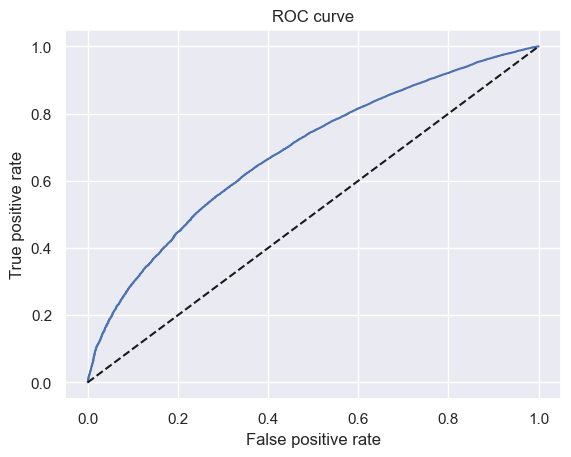

In [38]:
# Plotting the ROC curve herein
# false positive rate along the x-axis and the true positive rate along the y-axis,
plt.plot(fpr, tpr)
# Plotting a diagonal line, with dashed line style and black color.
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
# relabeling the axes
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [39]:
# Calculating AUROC from a set of actual values and their predicted probabilities.
AUROC = roc_auc_score(df_actual_predicted_probs['targets_test'],\
                      df_actual_predicted_probs['y_hat_test_proba'])
AUROC

0.6840759903759615

So, we found 0.68. It is above 0.50 so it shows a better performance of 1:1 line, a dummy model of probability of 0.50

## c Gini coefficient

Gini Index, aka Gini impurity, calculates the amount of probability of a specific feature that is classified incorrectly when randomly selected.

Gini index varies between values 0 and 1.  
Gini index of 0 =  the purity of classification. Each element belongs to a specified class or only one class exists there.  
Gini index of 1 = the random distribution of elements across various classes. 

The value of 0.5 of the Gini Index shows an equal distribution of elements over some classes.


In [40]:
#sorting proba values and resetting index
df_actual_predicted_probs = df_actual_predicted_probs.sort_values('y_hat_test_proba')
df_actual_predicted_probs = df_actual_predicted_probs.reset_index()
# calculating cumulative pop, good and bad
df_actual_predicted_probs['Cum N Population'] = df_actual_predicted_probs.index + 1
df_actual_predicted_probs['Cum N Good'] = df_actual_predicted_probs['targets_test'].cumsum()
df_actual_predicted_probs['Cum N Bad'] = df_actual_predicted_probs['Cum N Population']\
                                        - df_actual_predicted_probs['Cum N Good']
# Calculating the cumulative percentage of all, good, and bad observations.
sum_all= df_actual_predicted_probs.shape[0]
df_actual_predicted_probs['Cum Perc Population'] = df_actual_predicted_probs['Cum N Population'] / sum_all
# Calculating cumulative percentage of 'good'.
sum_good=  df_actual_predicted_probs['targets_test'].sum()
df_actual_predicted_probs['Cum Perc Good'] = df_actual_predicted_probs['Cum N Good'] /sum_good
# Calculating the cumulative percentage of 'bad'.
sum_bad = sum_all- sum_good
df_actual_predicted_probs['Cum Perc Bad'] = df_actual_predicted_probs['Cum N Bad'] / sum_bad


In [41]:
df_actual_predicted_probs.tail()

,index,targets_test,y_hat_test_proba,y_hat_test,Cum N Population,Cum N Good,Cum N Bad,Cum Perc Population,Cum Perc Good,Cum Perc Bad
93252,148031,1,0.988183,1,93253,83211,10042,0.999957,0.999952,1.0
93253,416618,1,0.988567,1,93254,83212,10042,0.999968,0.999964,1.0
93254,262480,1,0.988792,1,93255,83213,10042,0.999979,0.999976,1.0
93255,332098,1,0.989261,1,93256,83214,10042,0.999989,0.999988,1.0
93256,312703,1,0.989345,1,93257,83215,10042,1.000000,1.000000,1.0


In [42]:
df_actual_predicted_probs.head()

,index,targets_test,y_hat_test_proba,y_hat_test,Cum N Population,Cum N Good,Cum N Bad,Cum Perc Population,Cum Perc Good,Cum Perc Bad
0,79004,1,0.512051,0,1,1,0,0.000011,0.000012,0.0
1,118702,1,0.528653,0,2,2,0,0.000021,0.000024,0.0
2,107466,1,0.538931,0,3,3,0,0.000032,0.000036,0.0
3,465157,1,0.548781,0,4,4,0,0.000043,0.000048,0.0
4,352964,1,0.550576,0,5,5,0,0.000054,0.000060,0.0


Text(0.5, 1.0, 'Gini')

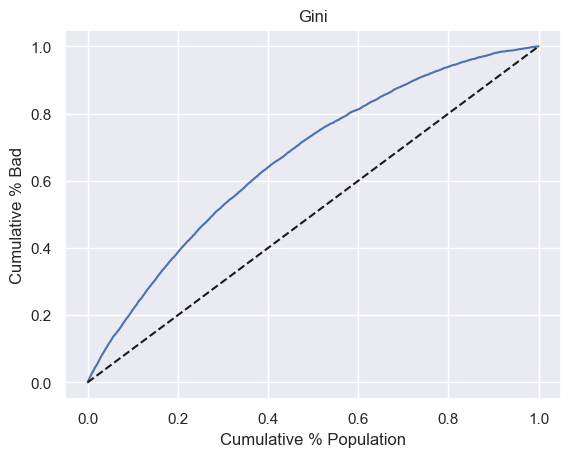

In [43]:
# Plotting Gini - cumulative percentage versus the cumulative percentage 'good' along the y-axis
plt.plot(df_actual_predicted_probs['Cum Perc Population'], df_actual_predicted_probs['Cum Perc Bad'])
# Plotting a seconary diagonal line, with dashed line style and black color.
plt.plot(df_actual_predicted_probs['Cum Perc Population'], df_actual_predicted_probs['Cum Perc Population'], linestyle = '--', color = 'k')
# Relabelling 
plt.xlabel('Cumulative % Population')
plt.ylabel('Cumulative % Bad')
plt.title('Gini')

In [44]:
# Here we calculate Gini from AUROC.
Gini = AUROC * 2 - 1
Gini

0.3681519807519229

The Gini coefficient is a ratio showing that

*  how close our model to be a “perfect model" (a Gini coef of 1)
*  how far our model to be from being a “random model” (a Gini coefficient of 0)

The GINI score of 0.37 shows that it can be improved by better building the PD model. For this example, we keep the model as it is. 

## d Kolmogorov-Smirnov coefficient

Kolomogrov-Smirnov (KS) coefficient evaluates the separation between class distributions.

KS statistics for two samples is simply the greatest distance between two cumulative distribution functions of the positive and negative class distributions. Similar to Gini coefficient, we can have another metric to evaluate classifiers.

Text(0.5, 1.0, 'Kolmogorov-Smirnov')

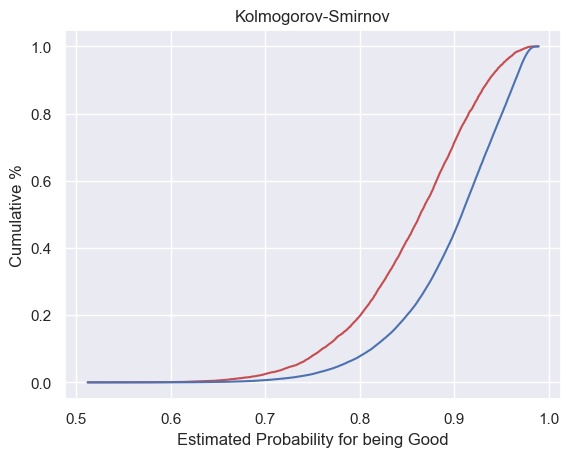

In [45]:
# Plotting KS 
# 1 predicted (estimated) probabilities versus the cumulative percentage 'bad' along the y-axis,
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cum Perc Bad'], color = 'r')
# 2 predicted (estimated) probabilities versus the cumulative percentage 'good' along the y-axis,
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cum Perc Good'], color = 'b')
# relabelling
plt.xlabel('Estimated Probability for being Good')
plt.ylabel('Cumulative %')
plt.title('Kolmogorov-Smirnov')

In [46]:
# Calculating KS from the data. 
# Max difference between the cumulative percentage of 'bad' and 'good'
KS = max(df_actual_predicted_probs['Cum Perc Bad'] - df_actual_predicted_probs['Cum Perc Good'])
KS

0.2701517377540078

# 4 Applying PD model for decision making


## a Creating scorecard

calculating credit worthiness - credit scores based on our PD model



In [47]:
df_ref_categories = pd.DataFrame(ref_categories,columns = ['Feature name'])
df_ref_categories['Coefficients'] = 0
df_ref_categories['p_values'] = np.nan

df_scorecard = pd.concat ([summary_table, df_ref_categories ])
df_scorecard = df_scorecard.reset_index()

df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard.head()

,index,Feature name,Coefficients,p_values,Original feature name
0,0,Intercept,0.260534,NaN,Intercept
1,1,grade:A,0.231117,7.824576e-03,grade
2,2,grade:B,0.305899,2.005733e-07,grade
3,3,grade:C,0.302560,4.430795e-08,grade
4,4,grade:D,0.296830,2.388592e-08,grade


In [48]:
#let's say we fix minimum score of 300 and max score of 850
min_score = 300
max_score = 850

In [49]:
#determining the ratio to multiply with the coefficients so that 
# min_score is equal to 300 and max_score is equal to 850
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
ratio_ = (max_score-min_score) / (max_sum_coef - min_sum_coef)
#calculating scores from coefs
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * ratio_
#replacing intercept coef
df_scorecard['Score - Calculation'][0] = (df_scorecard['Coefficients'][0] -\
                                           min_sum_coef)*ratio_+ min_score
#rounding the scores to integer like
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard.head()

/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_12234/4094337746.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_scorecard['Score - Calculation'][0] = (df_scorecard['Coefficients'][0] -\
/var/folders/y6/98pzw41d19qg3qhnh3w7

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,0.260534,NaN,Intercept,359.931207,360.0
1,1,grade:A,0.231117,7.824576e-03,grade,21.551286,22.0
2,2,grade:B,0.305899,2.005733e-07,grade,28.524539,29.0
3,3,grade:C,0.302560,4.430795e-08,grade,28.213208,28.0
4,4,grade:D,0.296830,2.388592e-08,grade,27.678908,28.0


In [50]:
#let's check if we have min score of 300 and max score of 800
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
#let's check if we have min score of 300 and max score of 800
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel, max_sum_score_prel)

300.0 850.0


Max score is 849. We need to alter and increase one of the scores by 1 pt. Let's print out the values rounded.

In [51]:
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
#let's check which index value to increase
df_scorecard['Difference'] =  df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
#let's print out the max scores of each feature
df_scorecard.loc[df_scorecard.groupby(['Original feature name'])['Score - Final'].idxmax()]

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Score - Final,Difference
0,0,Intercept,0.260534,NaN,Intercept,359.931207,360.0,360.0,0.068793
44,44,acc_now_delinq:>=1,0.148953,1.066817e-01,acc_now_delinq,13.889628,14.0,14.0,0.110372
21,21,addr_state:WV_NH_WY_DC_ME_ID,0.554444,7.829317e-25,addr_state,51.700956,52.0,52.0,0.299044
61,61,annual_inc:120K-140K,0.399902,5.474497e-14,annual_inc,37.290201,37.0,37.0,-0.290201
65,65,dti:3.5-7.7,0.121699,3.941103e-02,dti,11.348185,11.0,11.0,-0.348185
34,34,emp_length:10,0.132933,4.149772e-13,emp_length,12.395806,12.0,12.0,-0.395806
2,2,grade:B,0.305899,2.005733e-07,grade,28.524539,29.0,29.0,0.475461
8,8,home_ownership:MORTGAGE,0.124315,4.050512e-23,home_ownership,11.592199,12.0,12.0,0.407801
28,28,initial_list_status:w,0.270145,3.363811e-111,initial_list_status,25.190594,25.0,25.0,-0.190594
39,39,inq_last_6mths:0,0.027009,7.309697e-01,inq_last_6mths,2.518558,3.0,3.0,0.481442


In [52]:
#increasing the rounded score of some features 1+ to have max score of 850 at the end
df_scorecard['Score - Final'][21]  = 39 #coef will be adjusted one pt higher

/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_12234/1213069965.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_scorecard['Score - Final'][21]  = 39 #coef will be adjusted one pt higher
/var/folders/y6/98pzw41d19qg3qhnh3w7

In [53]:
#let's check if we have min score of 300 and max score of 800
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].min().sum()
min_sum_score_prel

np.float64(300.0)

In [54]:
#let's check if we have min score of 300 and max score of 800
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].max().sum()
max_sum_score_prel

np.float64(837.0)

**We finally have a min score of 300 and a max score of 850.**

Score card is ready!!! Let's Export It

In [55]:
inputs_test_ref_categories.to_csv('../data/inputs_train_with_ref_categories.csv')

In [56]:
df_scorecard.to_csv('../data/df_scorecard.csv')

##b Calculating Credit Scores

In [57]:
inputs_test_ref_categories.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35
362514,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
288564,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
213591,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
263083,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
165001,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [58]:
# test dataset with reference categories
inputs_test_with_ref_cat_w_intercept = inputs_train.loc[: , features_all]
# inserting the intercept point w an index of 0, that is, in the beginning of df
# The name of that column is 'Intercept', and its values are 1s.
inputs_test_with_ref_cat_w_intercept.insert(0,'Intercept', 1)
# ensuring that we selected the same features used in scorecard 
inputs_test_with_ref_cat_w_intercept = inputs_test_with_ref_cat_w_intercept [df_scorecard['Feature name'].values]

inputs_test_with_ref_cat_w_intercept.shape

(373028, 87)

In [59]:
#creating the score card array
scorecard_scores = df_scorecard['Score - Final']
scorecard_scores.shape

(87,)

In [60]:
#from list to an array
scorecard_scores = scorecard_scores.values.reshape(87,1)
# multiplying the values of each row of the dataframe by the values of each column of the variable,
# with 'dot' method (sum of the products)
y_scores = inputs_test_with_ref_cat_w_intercept.dot(scorecard_scores)

In [61]:
y_scores.head()

,0
427211,648.0
206088,567.0
136020,640.0
412305,456.0
36159,492.0


##c From Credit Score to Probability of Default



In [62]:
# Dividing the difference b/w the scores and the minimum score by diff b/w max and min score.
# Multiplying by the diff b/w max sum of coefs and min sum of coefs.
# Adding minimum sum of coefs.
coef_ =   (max_sum_coef - min_sum_coef) / (max_score - min_score) 
sum_coef_from_score = (y_scores - min_score) * coef_ + min_sum_coef
# dividing an exponent raised to sum of coefs from score by
# an exponent raised to sum of coefs from score plus one.
y_hat_proba_from_score = np.exp(sum_coef_from_score) / (np.exp(sum_coef_from_score) + 1)
y_hat_proba_from_score.head()

,0
427211,0.966098
206088,0.922810
136020,0.963173
412305,0.784279
36159,0.842487


##d Setting CutOffs

In [63]:
# Getting ROC Curve and their predicted probabilities.
# It returns us the false positive rates, the true positive rates, and the thresholds.
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['targets_test'],\
          df_actual_predicted_probs['y_hat_test_proba'])
# Conconating 3 dataframes along the columns.
df_cutoffs = pd.concat([pd.DataFrame(thresholds), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis = 1)
# Naming the columns of the dataframe 'thresholds', 'fpr', and 'tpr'.
df_cutoffs.columns = ['thresholds', 'fpr', 'tpr']

In [64]:
# Let the 1st threshold (the value of the thresholds column with index 0) be equal 
# very close to 1 but smaller than 1
df_cutoffs['thresholds'][0] = 1 - 1 / np.power(10, 20)

# The score corresponding to each threshold equals:
ratio_ = (max_score-min_score) / (max_sum_coef - min_sum_coef)
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * ratio_ + min_score).round()
df_cutoffs['Score'][0] = max_score

/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_12234/485229292.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_cutoffs['thresholds'][0] = 1 - 1 / np.power(10, 20)
/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_

In [65]:
# defining a function called 'n_approved' which assigns a value of 1 if a predicted probability
def n_approved(p):
    return np.where(df_actual_predicted_probs['y_hat_test_proba'] >= p, 1, 0).sum()

# With the assumption that a given probability of being 'good' will be approved,
# we obtain # of approved applications.
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)

# Calculating # of rejected applications for each threshold.
df_cutoffs['N Rejected'] = df_actual_predicted_probs['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']

# Approval rate = the ratio of the apprv'd apps and all apps.
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / df_actual_predicted_probs['y_hat_test_proba'].shape[0]

# Rejection rate.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']

In [66]:
# displaying the df with cutoffs form l/ w ind 5600 to l/ w ind 5650.
df_cutoffs.iloc[5600: 5650, ]

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
5600,0.904537,0.259211,0.525386,545.0,46323,46934,0.496724,0.503276
5601,0.904535,0.259311,0.525386,545.0,46324,46933,0.496735,0.503265
5602,0.904531,0.259311,0.525482,545.0,46332,46925,0.496821,0.503179
5603,0.904527,0.259510,0.525482,545.0,46334,46923,0.496842,0.503158
5604,0.904522,0.259510,0.525542,545.0,46339,46918,0.496896,0.503104
5605,0.904515,0.259610,0.525542,545.0,46340,46917,0.496906,0.503094
5606,0.904514,0.259610,0.525554,545.0,46341,46916,0.496917,0.503083
5607,0.904514,0.259610,0.525578,545.0,46343,46914,0.496939,0.503061
5608,0.904512,0.259610,0.525590,545.0,46344,46913,0.496949,0.503051
5609,0.904512,0.259709,0.525590,545.0,46345,46912,0.496960,0.503040


If the cutoff score is 495, half of the applications will be accepted for credit.

In [67]:
df_cutoffs.iloc[1000: 2000, ]
# Here we display the dataframe with cutoffs form line with index 1000 to line with index 2000.

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
1000,0.955907,0.039136,0.162915,623.0,13950,79307,0.149587,0.850413
1001,0.955907,0.039235,0.162915,623.0,13951,79306,0.149597,0.850403
1002,0.955852,0.039235,0.163288,622.0,13982,79275,0.149930,0.850070
1003,0.955852,0.039335,0.163288,622.0,13983,79274,0.149940,0.850060
1004,0.955806,0.039335,0.163600,622.0,14009,79248,0.150219,0.849781
...,...,...,...,...,...,...,...,...
1995,0.940918,0.084346,0.265866,594.0,22971,70286,0.246319,0.753681
1996,0.940914,0.084445,0.265866,594.0,22972,70285,0.246330,0.753670
1997,0.940907,0.084445,0.265998,594.0,22983,70274,0.246448,0.753552
1998,0.940906,0.084445,0.266022,594.0,22985,70272,0.246469,0.753531


If the cutoff score is 558, only about 15% of the applications will be accepted for credit.

## Results: Credit Risk PD Model, Scorecard, and Cutoff Analysis

### 1. Model Discriminatory Power

- **Gini Curve:**  
  The Gini plot demonstrates strong model performance. The blue line rises well above the dashed diagonal, indicating the model successfully ranks borrowers by risk—assigning higher predicted probabilities of default to riskier (bad) borrowers.
- **KS Curve (Kolmogorov-Smirnov):**  
  The maximum vertical distance between the red and blue lines (cumulative good vs. bad) reflects how well the model separates the two classes. A higher KS value confirms the model’s ability to distinguish good borrowers from bad ones.

---

### 2. Scorecard Construction

- **Score Range:**  
  The scorecard was scaled so the minimum possible score is 300 and the maximum is 850, matching industry practice for credit scoring.
- **Sample Feature Scores:**  
  Each variable and category receives a score proportional to its predictive power. For example:
  - `Intercept` contributes **360 points** to every applicant’s score.
  - `grade:B` adds **29 points** if the applicant’s loan grade is B.
  - `annual_inc:120K-140K` adds **37 points** for higher income, reflecting lower risk.
  - `int_rate:<9.548` adds **151 points** for the lowest interest rate loans, signaling very low risk.
  - `addr_state:WV_NH_WY_DC_ME_ID` adds **39 points** for borrowers from these states.

---

### 3. Confusion Matrix (Test Set, Threshold ≈ 0.9)

|               | Predicted Bad (0) | Predicted Good (1) |
|---------------|:-----------------:|:------------------:|
| **Actual Bad**  | 7,162           | 2,880              |
| **Actual Good** | 37,000          | 46,215             |

**Explanation:**  
- Of all truly bad (defaulting) accounts, the model correctly labeled **7,162** as bad (**True Negatives**) and misclassified **2,880** as good (**False Positives**).
- Of all truly good accounts, the model correctly labeled **46,215** as good (**True Positives**) and misclassified **37,000** as bad (**False Negatives**).
- The threshold used (0.9) is intentionally strict, prioritizing minimizing risk of defaults over maximizing approvals.

---

### 4. Cutoff and Approval Rate Analysis

- At a **score cutoff of approximately 545** (corresponding to a predicted probability of default of 0.90):
  - **Approval Rate:** About **49.7%** of applicants are approved.
  - **Rejection Rate:** About **50.3%** are rejected.
- **Interpretation:**  
  By adjusting the cutoff score, the business can increase approvals (at higher risk) or decrease risk (with fewer approvals), depending on its risk appetite.

---

### 5. Feature Importance

- The most influential factors in the scorecard include:
  - **Low interest rate loans (`int_rate:<9.548`)**: Highest score, strongest indicator of low risk.
  - **Loan grade (especially `grade:B`)**: Higher grades correspond to lower risk.
  - **High income (`annual_inc:120K-140K`)**: Higher income is associated with greater ability to repay.
  - **Certain states (`addr_state:WV_NH_WY_DC_ME_ID`)**: Borrowers from these states had statistically significant risk differences.
- **Interpretation:**  
  Features with higher scores reduce the applicant’s predicted risk of default.

---

### 6. Probability of Default Mapping

- Each applicant’s **credit score is mapped to a probability of default** using the logistic function:
  - **Score 648** → **PD ≈ 0.97** (very high risk)
  - **Score 567** → **PD ≈ 0.92**
  - **Score 456** → **PD ≈ 0.78** (moderate risk)
- **Interpretation:**  
  Lower scores mean higher probability of default and vice versa.

---

### 7. Business Implications

- The scorecard is interpretable and complies with regulatory requirements.
- Performance metrics (Gini, KS, confusion matrix) confirm strong predictive power.
- The cutoff score can be adjusted to suit business needs, balancing growth (approvals) and risk (defaults).

---


--- END OF NOTEBOOK ---  
#END